##Adding Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('/content/drive/My Drive/UdacityStudyJam/')

In [6]:
!unzip staticmap

Archive:  staticmap.zip
replace staticmap/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N
N


##Checking CUDA

In [7]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

CUDA is available!  Training on GPU ...


#Train Validation and Test Sets

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler



# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
                                ####Add Transforms####

    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.3 #### What portion would you like to allocate for validation?


# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



In [9]:
# specify the image classes
classes = ['Industrial','resedential']
len(train_idx)

1410

In [15]:
train_idx[0]
dataiter = iter(train_loader)
images, labels = dataiter.next()
images[0].shape  # image size

torch.Size([3, 120, 120])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

##See Sample Images

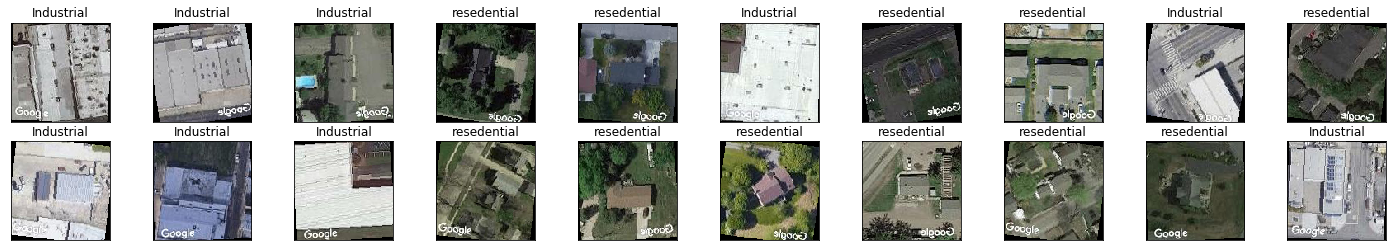

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Defining My Model

In [106]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        #---------------------

        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 15 * 15, 500)
        # linear layer (500 -> 2)
        self.fc2 = nn.Linear(500, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)



    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 15 * 15)

        #---------

        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


##Defining Loss Function and Optimizer

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005,momentum=0.7)



##Training

In [114]:
# try:
#   model.load_state_dict(torch.load('mymodel_for_sj.pt'))

# except:
#   max_acc=0
#   pass

max_acc=0

import pandas as pd
epochs = 30
steps = 0
running_loss = 0
print_every = 5
train_stats = pd.DataFrame(columns = ['Epoch',  'Train loss',
                                      'Test loss'])

for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            train_stats = train_stats.append({'Epoch': epoch, 
                                              'Train loss' : running_loss/len(train_loader),
                                     'Test loss' : test_loss/len(test_loader)}, ignore_index=True)
            test_acc = accuracy/len(test_loader)
            if test_acc >= max_acc:
              print('Validation acc increases ({:.6f} --> {:.6f}).  Saving model ...'.format(
              max_acc,
              test_acc))
              torch.save(model.state_dict(), 'mymodel_for_sj.pt')
              max_acc = test_acc
            running_loss = 0
            model.train()

Epoch 1/30.. Train loss: 0.332.. Test loss: 0.239.. Test accuracy: 0.900
Validation acc increases (0.000000 --> 0.900000).  Saving model ...
Epoch 1/30.. Train loss: 0.367.. Test loss: 0.268.. Test accuracy: 0.910
Validation acc increases (0.900000 --> 0.910000).  Saving model ...
Epoch 1/30.. Train loss: 0.386.. Test loss: 0.249.. Test accuracy: 0.923
Validation acc increases (0.910000 --> 0.923333).  Saving model ...
Epoch 1/30.. Train loss: 0.363.. Test loss: 0.247.. Test accuracy: 0.917
Epoch 1/30.. Train loss: 0.275.. Test loss: 0.247.. Test accuracy: 0.923
Validation acc increases (0.923333 --> 0.923333).  Saving model ...
Epoch 1/30.. Train loss: 0.338.. Test loss: 0.240.. Test accuracy: 0.917
Epoch 1/30.. Train loss: 0.338.. Test loss: 0.245.. Test accuracy: 0.900
Epoch 1/30.. Train loss: 0.409.. Test loss: 0.281.. Test accuracy: 0.907
Epoch 1/30.. Train loss: 0.321.. Test loss: 0.240.. Test accuracy: 0.907
Epoch 1/30.. Train loss: 0.322.. Test loss: 0.260.. Test accuracy: 0.90

##Validation accuracy

In [115]:
print( f"Validation accuracy: {max_acc*100:.3f}")

Validation accuracy: 93.667


##Loading Trained Model

In [116]:
model.load_state_dict(torch.load('mymodel_for_sj.pt'))


<All keys matched successfully>

##Testing

In [117]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.240110

Test Accuracy of Industrial: 93% (140/150)
Test Accuracy of resedential: 93% (140/150)

Test Accuracy (Overall): 93% (280/300)


##See Test Results

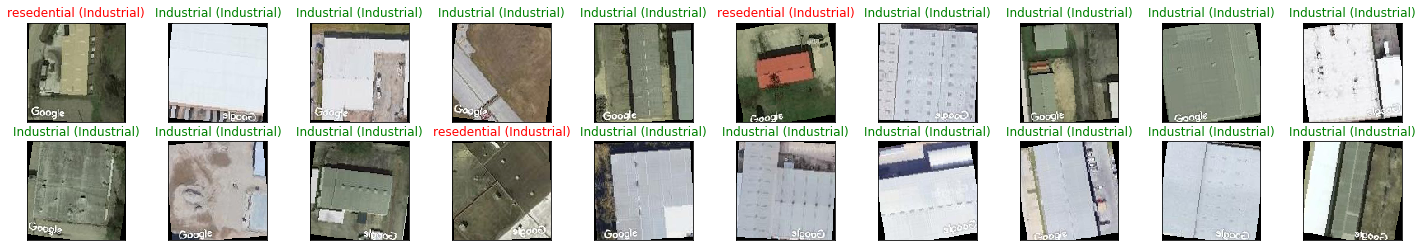

In [118]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))